In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from time import time
import spacy
from tld import get_tld
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
import os 
os.listdir('data')

['alllines.txt', '.DS_Store', 'Shakespeare_data.csv']

In [3]:
lines = list()
with open('data/alllines.txt') as f:
    lines.append(f.readlines())

In [4]:
lines[0][:10]

['"ACT I"\n',
 '"SCENE I. London. The palace."\n',
 '"Enter KING HENRY, LORD JOHN OF LANCASTER, the EARL of WESTMORELAND, SIR WALTER BLUNT, and others"\n',
 '"So shaken as we are, so wan with care,"\n',
 '"Find we a time for frighted peace to pant,"\n',
 '"And breathe short-winded accents of new broils"\n',
 '"To be commenced in strands afar remote."\n',
 '"No more the thirsty entrance of this soil"\n',
 '"Shall daub her lips with her own children\'s blood,"\n',
 '"Nor more shall trenching war channel her fields,"\n']

In [5]:
shakespeare = pd.read_csv('data/Shakespeare_data.csv')
shakespeare.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


# Exploratory Analysis

In [6]:
shakespeare.shape

(111396, 6)

In [7]:
shakespeare['Play'].value_counts()

Hamlet                      4244
Coriolanus                  3992
Cymbeline                   3958
Richard III                 3941
Antony and Cleopatra        3862
King Lear                   3766
Othello                     3762
Troilus and Cressida        3711
A Winters Tale              3489
Henry VIII                  3419
Henry V                     3395
Henry VI Part 2             3334
Romeo and Juliet            3313
Henry IV                    3205
Henry VI Part 3             3138
Alls well that ends well    3083
Measure for measure         2998
Loves Labours Lost          2986
Henry VI Part 1             2983
Richard II                  2937
Merry Wives of Windsor      2831
As you like it              2822
Taming of the Shrew         2806
Merchant of Venice          2802
Julius Caesar               2771
King John                   2766
Titus Andronicus            2726
Much Ado about nothing      2704
Timon of Athens             2662
Twelfth Night               2648
Pericles  

In [8]:
shakespeare.groupby('Play')['Player'].value_counts()

Play                      Player            
A Comedy of Errors        DROMIO OF SYRACUSE     323
                          OF SYRACUSE            292
                          ADRIANA                284
                          OF EPHESUS             221
                          DROMIO OF EPHESUS      191
                          AEGEON                 150
                          LUCIANA                118
                          ANGELO                  99
                          DUKE SOLINUS            97
                          AEMELIA                 75
                          Courtezan               43
                          Second Merchant         41
                          BALTHAZAR               31
                          First Merchant          19
                          Officer                 17
                          PINCH                   17
                          Servant                 16
                          LUCE                    11
 

In [9]:
class TextCleaner(TransformerMixin):
    """Text cleaning to slot into sklearn interface"""

    def __init__(self, remove_stopwords=True, remove_urls=True,
                 remove_puncts=True, lemmatize=True, extra_punct='',
                 custom_stopwords=[], custom_non_stopwords=[],
                 verbose=True, parser='big'):
        """
        INPUT: remove_stopwords - bool - remove is, there, he etc...
               remove_urls - bool - 't www.monkey.com t' --> 't com t'
               remove_punct - bool - all punct and digits gone
               lemmatize - bool - whether to apply lemmtization
               extra_punct - str - other characters to remove
               custom_stopwords - list - add to standard stops
               custom_non_stopwords - list - make sure are kept
               verbose - bool - whether to print progress statements
               parser - str - 'big' or small, one keeps more, and is slower
        OUTPUT: self - **due to other method, not this one
        """
        # Initialize passed Attributes to specify operations
        self.remove_stopwords = remove_stopwords
        self.remove_urls = remove_urls
        self.remove_puncts = remove_puncts
        self.lemmatize = lemmatize

        # Change how operations work
        self.custom_stopwords = custom_stopwords
        self.custom_non_stopwords = custom_non_stopwords
        self.verbose = verbose

        # Set up punctation tranlation table
        self.removals = string.punctuation + string.digits + extra_punct
        self.trans_table = str.maketrans({key: None for key in self.removals})

        #Load nlp model for parsing usage later
        self.parser = spacy.load('en_core_web_sm', 
                                 disable=['parser','ner','textcat'])
        #from spacy.lang.en import English
        if parser == 'small':
            self.parser = spacy.load('en')#English()

        #Add custom stop words to nlp
        for word in self.custom_stopwords:
            self.parser.vocab[word].is_stop = True

        #Set custom nlp words to be kept
        for word in self.custom_non_stopwords:
            self.parser.vocab[word].is_stop = False


    def transform(self, X, y=None):
        """take array of docs to clean array of docs"""
        # Potential replace urls with tld ie www.monkey.com to com
        if self.remove_urls:
            start_time = time()
            if self.verbose:
                print("CHANGING URLS to TLDS...  ", end='')
            X = [self.remove_url(doc) for doc in X]
            if self.verbose:
                print(f"{time() - start_time:.0f} seconds")

        # Potentially remove punctuation
        if self.remove_puncts:
            start_time = time()
            if self.verbose:
                print("REMOVING PUNCTUATION AND DIGITS... ", end='')
            X = [doc.lower().translate(self.trans_table) for doc in X]
            if self.verbose:
                print(f"{time() - start_time:.0f} seconds")

        # Using Spacy to parse text
        start_time = time()
        if self.verbose:
            print("PARSING TEXT WITH SPACY... ", end='')
            
        X = list(self.parser.pipe(X))
        if self.verbose:
            print(f"{time() - start_time:.0f} seconds")

        # Potential stopword removal
        if self.remove_stopwords:
            start_time = time()
            if self.verbose:
                print("REMOVING STOP WORDS FROM DOCUMENTS... ", end='')
            X = [[word for word in doc if not word.is_stop] for doc in X]
            if self.verbose:
                print(f"{time() - start_time:.0f} seconds")


        # Potential Lemmatization
        if self.lemmatize:
            start_time = time()
            if self.verbose:
                print("LEMMATIZING WORDS... ", end='')
            X = [[word.lemma_ for word in doc] for doc in X]
            if self.verbose:
                print(f"{time() - start_time:.0f} seconds")

        # Put back to normal if no lemmatizing happened
        if not self.lemmatize:
            X = [[str(word).lower() for word in doc] for doc in X]

        # Join Back up
        return [' '.join(lst) for lst in X]


    def fit(self, X, y=None):
        """interface conforming, and allows use of fit_transform"""
        return self


    @staticmethod
    def remove_url(text):
        """
        DESCR: given a url string find urls and replace with top level domain
               a bit lazy in that if there are multiple all are replaced by first
        INPUT: text - str - 'this is www.monky.com in text'
        OUTPIT: str - 'this is <com> in text'
        """
        # Define string to match urls
        url_re = '((?:www|https?)(://)?[^\s]+)'

        # Find potential things to replace
        matches = re.findall(url_re, text)
        if matches == []:
            return text

        # Get tld of first match
        match = matches[0][0]
        try:
            tld = get_tld(match, fail_silently=True, fix_protocol=True)
        except ValueError:
            tld = None

        # failures return none so change to empty
        if tld is None:
            tld = ""

        # make this obvsiouyly an odd tag
        tld = f"<{tld}>"

        # Make replacements and return
        return re.sub(url_re, tld, text)

In [10]:
custom_stopwords = []# ['act', 'i', 'ii', 'iii', 'iv', 'v']
shakespeare['PlayerLineClean'] = TextCleaner(
    custom_stopwords=custom_stopwords, remove_urls=False).transform(shakespeare['PlayerLine'])

REMOVING PUNCTUATION AND DIGITS... 0 seconds
PARSING TEXT WITH SPACY... 35 seconds
REMOVING STOP WORDS FROM DOCUMENTS... 1 seconds
LEMMATIZING WORDS... 0 seconds


In [11]:
shakespeare.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,PlayerLineClean
0,1,Henry IV,NaN,NaN,NaN,ACT I,act
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.,scene london palace
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ...",enter king henry lord john lancaster earl west...
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,",shake wan care
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,",find time frighted peace pant


# Test `DBSCAN` with Word Embeddings

- Issues [described in Stack Overflow](https://stackoverflow.com/questions/25217065/scikit-learn-clustering-text-documents-using-dbscan) that input data can't be sparse with `sklearn`'s implementation of `DBSCAN`.  

In [54]:
# word embeddings
import gensim

sentences = []
for line in shakespeare.PlayerLineClean.tolist():
    sentences.append(line.split())

model = gensim.models.Word2Vec(iter=1, min_count=3, size=500, workers=4)
model.build_vocab(sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

(324762, 368709)

In [55]:
word_vectors = model.wv
word_vectors.vectors

array([[-1.8252939e-01,  1.8991718e-01, -1.9270381e-01, ...,
        -5.1900361e-02, -3.1641909e-01, -3.5205271e-02],
       [-1.6456056e-01,  1.6780211e-01, -1.7022605e-01, ...,
        -4.8473675e-02, -2.8080851e-01, -3.3235200e-02],
       [-1.3986461e-01,  1.4338857e-01, -1.4471832e-01, ...,
        -4.0917829e-02, -2.3949753e-01, -2.7954664e-02],
       ...,
       [-2.7349583e-05, -4.7575106e-04,  3.0752443e-04, ...,
        -3.5478646e-04, -7.1973144e-04,  4.6954711e-04],
       [-8.6977414e-04, -1.2982711e-04,  3.9533246e-04, ...,
         7.0971844e-04,  4.2426470e-04, -7.3269842e-04],
       [ 3.5271740e-05,  1.7609933e-04, -1.9333573e-04, ...,
        -9.9531433e-04, -9.7591692e-04,  5.4328615e-04]], dtype=float32)

In [56]:
wv_df = pd.DataFrame(word_vectors.vectors, index=word_vectors.vocab.keys()).T
wv_df.head()

,act,scene,london,palace,enter,king,henry,lord,john,lancaster,earl,westmoreland,sir,walter,blunt,shake,wan,care,find,time,peace,pant,breathe,accent,new,broil,commence,strand,afar,remote,thirsty,entrance,soil,shall,daub,lip,children,blood,trench,war,channel,field,bruise,armed,hoofs,hostile,pace,opposed,eye,like,meteor,troubled,heaven,nature,substance,breed,lately,meet,shock,furious,close,civil,butchery,mutual,rank,march,way,acquaintance,kindr,ally,edge,knife,cut,master,friend,far,sepulchre,christ,soldier,bless,cross,engage,fight,forthwith,power,english,levy,arm,mould,mother,womb,chase,pagan,holy,acre,walkd,blessed,foot,fourteen,year,ago,advantage,bitter,purpose,month,old,bootless,tis,tell,let,hear,gentle,cousin,yesternight,council,decree,forward,dear,expedience,liege,haste,hot,question,limit,charge,set,athwart,come,post,wale,loaden,heavy,news,bad,noble,mortimer,lead,man,irregular,wild,glendower,rude,hand,welshman,take,thousand,people,butcher,dead,corpse,misuse,beastly,shameless,transformation,shame,retell,speak,tiding,brake,business,land,matchd,gracious,uneven,unwelcome,north,import,day,gallant,hotspur,young,harry,percy,brave,approve,scot,holmedon,spend,sad,bloody,hour,discharge,artillery,shape,likelihood,bring,heat,pride,contention,horse,uncertain,issue,true,industrious,staind,variation,betwixt,seat,hath,smooth,welcome,douglas,discomfit,bold,knight,plain,prisoner,mordake,fife,eld,son,dougla,angus,menteith,honourable,spoil,prize,ha,faith,conquest,prince,boast,yea,thou,mak,makest,sin,envy,northumberland,father,blest,theme,honours,tongue,grove,plant,sweet,fortune,minion,whilst,look,praise,riot,dishonour,stain,brow,o,prove,fairy,exchange,child,lie,calld,plantagenet,thought,think,coz,percys,adventure,surprise,use,keep,send,word,uncle,teach,worcester,aspect,make,prune,bristle,crest,youth,dignity,answer,cause,awhile,neglect,jerusalem,wednesday,hold,windsor,inform,speed,say,anger,utter,exeunt,ii,apartment,falstaff,hal,lad,art,drinking,sack,unbutton,thee,supper,sleep,bench,noon,hast,forget,demand,truly,wouldst,know,devil,cup,minute,capon,clock,bawds,dial,sign,sun,fair,wench,taffeta,reason,shouldst,superfluous,near,purse,moon,seven,star,phoebus,wander,prithee,wag,god,save,thy,grace,wilt,troth,serve,prologue,egg,butter,roundly,marry,squire,night,body,call,thief,beauty,dianas,forester,gentleman,shade,good,government,govern,sea,chaste,mistress,countenance,steal,sayest,doth,ebb,flow,proof,gold,resolutely,snatch,monday,dissolutely,tuesday,morning,get,swear,lay,cry,low,ladder,high,ridge,gallow,hostess,tavern,honey,castle,buff,jerkin,robe,durance,mad,quip,plague,pox,reckoning,oft,pay,ill,coin,stretch,credit,apparent,heir,stand,england,resolution,rusty,curb,antic,law,hang,shalt,rare,judge,false,mean,hanging,hangman,sort,jump,humour,wait,court,obtain,suit,whereof,lean,wardrobe,sblood,melancholy,cat,lug,bear,lion,lover,lute,drone,bagpipe,hare,unsavoury,simile,comparative,trouble,vanity,commodity,name,buy,rat,street,mark,talk,wisely,regard,didst,wisdom,damnable,iteration,able,corrupt,saint,harm,forgive,little,wicked,life,villain,damn,christendom,tomorrow,jack,zound,baffle,amendment,pray,ti,vocation,labour,poin,gadshill,match,merit,hole,hell,omnipotent,morrow,n,monsieur,remorse,sugar,agree,soul,cold,leg,bargain,proverb,damned,cozen,oclock,...,sophy,launcelot,gobbo,jews,gramercy,jessica,torchbearer,wildcat,masqu,huggd,bassanios,inscription,chooseth,arragon,distinct,ivory,genoa,grossness,salerio,magnifico,balthasar,padua,bellario,envys,pythagora,daniel,exposition,award,desir,recant,thisbe,carthage,unthrift,stephano,moonlight,beset,evan,got,goot,fery,abraham,tam,cashier,oman,decrease,bullyrook,singer,conycatch,pandarus,rogu,phrygian,rugby,fe,dere,vill,brew,ann,gar,fenton,thinkest,nan,actaeon,pottle,recourse,attraction,nayword,largely,excellency,fords,aggravate,curer,frogmore,knog,urinal,fragrant,falstaffs,carryt,buckbasket,farthingale,welladay,dissolute,abird,slide,slend,alacrity,pill,polecat,lapis,brentford,g,dishonesty,hung,scrape,herne,urchin,eton,

In [57]:
wv_df.shape

(500, 8980)

In [68]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=.5, min_samples=10)
db.fit(wv_df)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

labels[:5]

array([0, 0, 0, 0, 0])

Estimated number of clusters: 1
Estimated number of noise points: 1


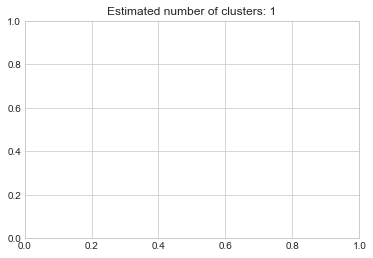

In [69]:
from sklearn import metrics
%matplotlib inline

X = wv_df

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Test Classification

- Try predicting the `Act`, derived from `ActSceneLine`
- Test different pre-processing techniques

In [74]:
shakespeare.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,PlayerLineClean
0,1,Henry IV,NaN,NaN,NaN,ACT I,act
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.,scene london palace
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ...",enter king henry lord john lancaster earl west...
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,",shake wan care
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,",find time frighted peace pant


In [ ]:
# shakespeare['Act'] = 
for ix, l in enumerate(shakespeare['ActSceneLine']):
    shakespeare.loc[ix, 'Act'] = str(str(l).split('.')[0])
    
shakespeare = shakespeare.loc[shakespeare['Act'] != 'nan']
shakespeare.head()

In [75]:
# for each name, derive beginning middle and end
for name, _df in shakespeare.groupby('Play'):
    end_act1 = _df.Dataline.quantile(.33)
    end_act2 = _df.Dataline.quantile(.66)

    df['']

23105.82
67755.67
109059.04000000001
13678.060000000001
19840.13
16674.93
25800.030000000002
29780.809999999998
33833.19
1058.32
37797.020000000004
4190.0599999999995
7288.89
10558.21
41199.94
47171.1
44403.45
50270.45
53779.049999999996
59355.01
62288.33
65099.9
70188.99
73242.13
76634.2
79372.88
82641.20000000001
86374.96
89520.65
92193.66
94682.13
97365.25
100416.3
103776.51000000001
106328.48
56633.049999999996


In [71]:
shakespeare.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,PlayerLineClean
0,1,Henry IV,NaN,NaN,NaN,ACT I,act
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.,scene london palace
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ...",enter king henry lord john lancaster earl west...
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,",shake wan care
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,",find time frighted peace pant


In [ ]:
lines_clean